In [1]:
import numpy as np
import pandas as pd
from to_img import to_img

from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



colors = ['navy', 'turquoise', 'brown', 'red', 'black','green', 'orange', 'pink']

## 1. Data
The data for this project comes from https://www.imdb.com/interfaces/ as extremely large .tsv (tab-seperated) files, the biggest being over 2GB. In order to conduct train the KMeans++ model I will need to combine all of this data. But first, in order to load it without overloading my system I need to apply some data wranging and engineering. The need for each of these files is briefly explained below.

- akas: I need region data so I can narrow the data to 'US' based films.
- basics: contains movie specific info
- name: contains names of cast and crew along with their reference code (nconst)
- principals: contains order of precedence if more than one nconst (person) is referenced to the same role (i.e. lead vs co-directors)
- ratings: holds IMDB user rating and vote counts

I'm handling this huge memory load by using pandas to read load the data in chunk, and filtering out specific columns and values that are irrelevant to the project. The data is then saved to a .csv file to ensure stability (of my machine) that I load back in.

As of right now, there's a bit of SQL at the bottom of this file that I'm tinkering with.
Also, the data dictionary on imdb.com is incorrect. I'll provide one once the data has been trimmed down and consolidated.

### 1.1 Load .tsv Files
'usecols' is a useful parameter for speeding up the reading in of large files because I can specify just the columns I need pandas to parse.

In .read_csv iterator and chunksize let me specify how much data from each .tsv file will be preprocessed before being recomiled into a dataframe.

In [ ]:
def chunks(path,cols):
    """
    Summary: loads .tsv files in chunks, selecting specific features and filtering unnecessary values.
        _
    Args:
        path (string): local address
        cols (list): features to keep
    Returns:
       df_result (pd.DataFrame): preprocessed dataframe
    """
    PATH = path
    my_chunk = 100000
    # sets up the size and parameters of the file reader
    iter_csv = pd.read_csv(
        PATH,
        na_values=['\\N','nan'],
        delimiter='\t',
        iterator=True,
        dtype='object',
        chunksize=my_chunk,
        usecols=cols)
    
    # the following logic follows that when the function is called, if the string arguement passed through as the path parameter matches the case string, a speciic data engineering process is executed for that specific data.
    if 'rating' in PATH:
        df_result = pd.concat([chunk for chunk in iter_csv])
        #df_result = pd.concat([chunk[chunk.averageRating.astype('float') > 5] for chunk in iter_csv])
    elif 'name' in PATH:
        df_result = pd.concat([chunk for chunk in iter_csv])
    elif 'principals' in PATH:
        # there's a number of roles that barely appear in the data.
        #TODO roll these into an 'other'
        principal_roles = ['actor', 'actress','director','writer','producer','composer']
        df_result = pd.concat(
            [chunk[(chunk['ordering'].astype('int') <= 3) & (chunk['category'].isin(principal_roles))]
            for chunk in iter_csv])
        
    elif 'akas' in PATH:
        df_result = pd.concat([chunk[chunk.region == 'US'] for chunk in iter_csv])
        df_result.rename({'titleId': 'tconst'}, axis=1, inplace=True)
    elif 'basics' in PATH:
        # Many films have a list of genres which explodes in dimensionality when one hot encoding. So instead, I'm sticking with the films that're 'quisessentially' a specific genre.
        principle_genres = ['Drama','Comedy','Adventure','Action', 'Horror', 'Thriller', 'Fantasy', 'Crime', 'Family', 'Sci-Fi', 'Mystery',
            'Romance']
        # I also observed a high skew to startYear values so I'm also limiting the scope of the data to just the past 2+ decades.
        df_result = pd.concat([chunk[
            (chunk.titleType == 'movie')
            & (chunk.startYear.between('2000', '2022'))
            & (chunk['genres'].isin(principle_genres))] for chunk in iter_csv])
        
        df_result.startYear = pd.to_numeric(df_result.startYear)
        df_result.runtimeMinutes = pd.to_numeric(df_result.runtimeMinutes)
        df_result = df_result[df_result.runtimeMinutes >= 70]
        df_result.runtimeMinutes = pd.to_numeric(df_result.runtimeMinutes)
        df_result = df_result.drop('titleType', axis=1)
        
    df_result.columns = map(str.lower, df_result.columns)

    return pd.DataFrame(df_result)

In [ ]:

# Each .tsv file is loaded by calling the chunks function using a list of its columns and the local directory.

col_list = ['tconst','titleType','primaryTitle','startYear','genres','runtimeMinutes']
basics_tsv = '../Data/tsv/basics.tsv'
basics = pd.DataFrame(chunks(basics_tsv,col_list))


col_list = ['titleId','region']
akas_tsv = '../Data/tsv/akas.tsv'
akas = pd.DataFrame(chunks(akas_tsv,col_list))


col_list = ['tconst','ordering','nconst','category'	]
principals_tsv = '../Data/tsv/principals.tsv'
principals = pd.DataFrame(chunks(principals_tsv,col_list))


col_list = ['nconst', 'primaryName']
names_tsv = '../Data/tsv/name.tsv'
names = pd.DataFrame(chunks(names_tsv,col_list))


col_list = ['tconst','averageRating','numVotes']
ratings_tsv = '../Data/tsv/ratings.tsv'
ratings = pd.DataFrame(chunks(ratings_tsv,col_list))


col_list = ['tconst','averageRating','numVotes']
ratings_tsv = '../Data/tsv/ratings.tsv'
ratings = pd.DataFrame(chunks(ratings_tsv,col_list))

In [ ]:
# Taking a quick look at each table.
basics.info(memory_usage='deep')
basics.head(3)

In [ ]:
akas.info(memory_usage='deep')
akas.head(3)

In [ ]:
#note the foreign key, 'nconst'.
principals.info(memory_usage='deep')
principals.head(3)

In [ ]:
names.info(memory_usage='deep')
names.head(3)

In [ ]:
ratings.info(memory_usage='deep')
ratings.head(3)

### 1.2 Merging Tables
First, the basics table is filtered by a list of tconst (film specific) values for films that were identified in the akas table as being from the 'US' region.
Then the tconst and nconst (person specific) keys are used to merge each table.


In [ ]:
# filtering basics down to only movies from the 'US' region. This'll greatly reduced everything being add from the other tables.
tconst = list(set(akas.tconst.values))
basics = basics[basics['tconst'].isin(tconst)]

data = basics.merge(principals, how='left',on='tconst')
data = data.merge(ratings, how='left',on='tconst')
data = data.merge(names, how='left',on='nconst')

data.drop(['nconst'],axis=1,inplace=True)
data.dropna(inplace=True)
data.to_csv('../Data/data.csv', index=False)
print(len(data))
print(data.info(memory_usage='deep'))
data.head()

### 1.3 Reload and Inspect Data

In [2]:
# note the change in memory usage.
data = pd.read_csv('../Data/data.csv')
print(len(data))
to_img(data.head(),name='1.3_loaded_data')
data.info(memory_usage='deep')
data.head()

69195
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69195 entries, 0 to 69194
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          69195 non-null  object 
 1   primarytitle    69195 non-null  object 
 2   startyear       69195 non-null  int64  
 3   runtimeminutes  69195 non-null  float64
 4   genres          69195 non-null  object 
 5   ordering        69195 non-null  int64  
 6   category        69195 non-null  object 
 7   averagerating   69195 non-null  float64
 8   numvotes        69195 non-null  int64  
 9   primaryname     69195 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 24.8 MB


,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname
0,tt0062336,The Tango of the Widower and Its Distorting Mi...,2020,70.0,Drama,1,actor,6.4,161,Rubén Sotoconil
1,tt0062336,The Tango of the Widower and Its Distorting Mi...,2020,70.0,Drama,2,actress,6.4,161,Claudia Paz
2,tt0062336,The Tango of the Widower and Its Distorting Mi...,2020,70.0,Drama,3,actor,6.4,161,Luis Alarcón
3,tt0069049,The Other Side of the Wind,2018,122.0,Drama,1,actor,6.7,7160,John Huston
4,tt0069049,The Other Side of the Wind,2018,122.0,Drama,2,actress,6.7,7160,Oja Kodar


data dictionary

- tconst  =   title id of the movie
- primarytitle    =   primary title the movie goes by
- startyear   =   year realease
- runtimeminutes  =   film duration
- genres  =   list of each genre the film represents
- ordering    =   order of precedence if co-directors/writers/producers
- nconst  =   name id or director, writer
- category    =   job category
- primaryname =   director/writer name gone by
- averagerating   =   films average rating
- numvotes    =   number of votes film has received

In [3]:
# check for duplcates.
print(f'Number of dupes: {sum(data.duplicated())}')
data[data.duplicated() == True]

#data.drop_duplicates(inplace=True)
#data[data.duplicated() == True]

Number of dupes: 0


,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname


In [4]:
# check for null values
data[data.isnull().any(axis=1)]

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname


In [5]:
# just doublechecking.
data.isna().sum()

tconst            0
primarytitle      0
startyear         0
runtimeminutes    0
genres            0
ordering          0
category          0
averagerating     0
numvotes          0
primaryname       0
dtype: int64

## 2. Initial EDA: Features
### 2.1 Data Diagnosis

In [6]:
data.describe(include='all')

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname
count,69195,69195,69195.000000,69195.000000,69195,69195.000000,69195,69195.000000,69195.000000,69195
unique,23208,22151,NaN,NaN,12,NaN,6,NaN,NaN,52110
top,tt3257092,Home,NaN,NaN,Drama,NaN,actor,NaN,NaN,Eric Roberts
freq,3,21,NaN,NaN,35033,NaN,40552,NaN,NaN,44
mean,NaN,NaN,2013.141195,96.186618,NaN,1.998208,NaN,5.857932,1867.412053,NaN
std,NaN,NaN,5.729073,19.257263,NaN,0.816447,NaN,1.424476,17752.278672,NaN
min,NaN,NaN,2000.000000,70.000000,NaN,1.000000,NaN,1.000000,5.000000,NaN
25%,NaN,NaN,2009.000000,85.000000,NaN,1.000000,NaN,5.000000,32.000000,NaN
50%,NaN,NaN,2014.000000,93.000000,NaN,2.000000,NaN,6.000000,115.000000,NaN
75%,NaN,NaN,2018.000000,103.000000,NaN,3.000000,NaN,6.800000,421.000000,NaN


### 2.2 Categorical Features
I have to pay special attention here. Note that 'primarytitle' and 'primaryname' would dramatically insrease the dimensionality of the data. Something that I noticed in an earlier iteration is that 'primary' titles are sometimes duplicated, which makes sense because some movies share their title with another, such as in the case of remakes. Therefore, I don't think primary title is a feature I should use.

In [7]:
data.select_dtypes('object').nunique()

tconst          23208
primarytitle    22151
genres             12
category            6
primaryname     52110
dtype: int64

In [8]:
to_img(data.select_dtypes('object').head(), name='2.2_categorical_features')
data.select_dtypes('object')

,tconst,primarytitle,genres,category,primaryname
0,tt0062336,The Tango of the Widower and Its Distorting Mi...,Drama,actor,Rubén Sotoconil
1,tt0062336,The Tango of the Widower and Its Distorting Mi...,Drama,actress,Claudia Paz
2,tt0062336,The Tango of the Widower and Its Distorting Mi...,Drama,actor,Luis Alarcón
3,tt0069049,The Other Side of the Wind,Drama,actor,John Huston
4,tt0069049,The Other Side of the Wind,Drama,actress,Oja Kodar
...,...,...,...,...,...
69190,tt9913660,No Apology,Drama,actor,Owen Bishop
69191,tt9913660,No Apology,Drama,actor,Pierce Briggs
69192,tt9914942,Life Without Sara Amat,Drama,actress,Maria Morera
69193,tt9914942,Life Without Sara Amat,Drama,actor,Biel Rossell Pelfort


##### 2.2.a - tsconst
This feature plays a huge factor in my analysis because it's the marker for distinct movies. Sometimes a 'tconst' value will appear multiple times, this happens because some movies have mutiple people associated with it; so a film with a director, actor, and actress will have three seperate entries.

In [9]:
data.tconst.describe()

count         69195
unique        23208
top       tt3257092
freq              3
Name: tconst, dtype: object

##### 2.2.b - primarytitle

In [10]:
data.primarytitle.value_counts()

Home                                   21
Blackbird                              18
Alice                                  15
Hunting Season                         15
Still Life                             15
                                       ..
Hollywood Babble-on Live 5/22/2011      1
Surge of Power: The Stuff of Heroes     1
A Silent Way                            1
Sean Lock: Keep It Light - Live         1
The Gulf of Silence                     1
Name: primarytitle, Length: 22151, dtype: int64

##### 2.2.c - genres

In [11]:
data.genres.value_counts()


Drama        35033
Comedy       14004
Horror        8165
Thriller      5011
Action        1984
Romance       1481
Family         991
Sci-Fi         785
Crime          616
Mystery        420
Adventure      391
Fantasy        314
Name: genres, dtype: int64

##### 2.2.d - category

In [12]:
data.category.value_counts()

actor       40552
actress     28096
director      414
producer       58
writer         42
composer       33
Name: category, dtype: int64

In [13]:
# further reducing the number of possible categorical values.
keeps = ['actor', 'actress', 'director']
data = data[data.category.isin(keeps)]

##### 2.2.e - primaryname
This is a huge source of dimensionality. For now I'm simply going to drop anyone who appears only once. This is hand during the .tsv file conversion process further up but I may fine tune here in the the future.

In [14]:
#data = data[data.groupby("primaryname")['primaryname'].transform('size') > 5]
print(data.primaryname.value_counts())
data = data[data.groupby("primaryname")['primaryname'].transform('size') > 1]
data

Eric Roberts        44
Michael Madsen      29
Tom Sizemore        26
Kevin Sorbo         20
Isabelle Huppert    20
                    ..
Otis P. Otis         1
Maxim Vengerov       1
Sang-hee Lee         1
Cheryl Allison       1
Facundo Cardosi      1
Name: primaryname, Length: 51981, dtype: int64


,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname
5,tt0069049,The Other Side of the Wind,2018,122.0,Drama,3,actor,6.7,7160,Peter Bogdanovich
9,tt0096056,Crime and Punishment,2002,126.0,Drama,1,actor,5.7,810,Crispin Glover
10,tt0096056,Crime and Punishment,2002,126.0,Drama,2,actress,5.7,810,Vanessa Redgrave
11,tt0096056,Crime and Punishment,2002,126.0,Drama,3,actor,5.7,810,John Hurt
27,tt0118852,Chinese Coffee,2000,99.0,Drama,1,actor,7.1,4254,Al Pacino
...,...,...,...,...,...,...,...,...,...,...
69170,tt9900688,Big Three Dragons,2019,111.0,Comedy,3,actor,4.5,29,Chia-Chia Peng
69171,tt9902160,Herself,2020,97.0,Drama,1,actress,7.0,3273,Molly McCann
69182,tt9904552,All for the Money,2019,107.0,Comedy,3,actor,7.6,6,Simeon Henderson
69183,tt9904648,The Contrast,2022,82.0,Comedy,1,actor,4.2,18,Lance E. Nichols


In [15]:
print(data.primaryname.value_counts())

Eric Roberts        44
Michael Madsen      29
Tom Sizemore        26
Kevin Sorbo         20
Isabelle Huppert    20
                    ..
Ecem Uzun            2
Rani Mukerji         2
Darya Astafieva      2
Tsahi Halevi         2
Joey Fatone          2
Name: primaryname, Length: 9421, dtype: int64


In [16]:
data.select_dtypes('object')
to_img(data.select_dtypes('object').head(), name='2.2_categorical_features_post')

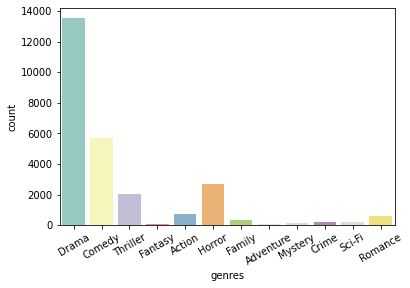

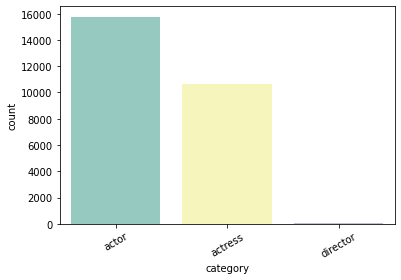

In [17]:
# so much drama...
for f in data[['genres','category']]:
    sns.countplot(x = f, data = data, palette = 'Set3') # hue = '')
    plt.xticks(rotation=30)
    plt.savefig(f'../Images/cat_countplot_{f}.jpg')
    plt.show()
    

### 2.3 Numeric Features

In [18]:
old = data.describe()
data.select_dtypes('number').nunique()

startyear           23
runtimeminutes     142
ordering             3
averagerating       89
numvotes          3047
dtype: int64

In [19]:
to_img(data.select_dtypes('number').head(), name='2.3_numeric_features')
data.select_dtypes('number')

,startyear,runtimeminutes,ordering,averagerating,numvotes
5,2018,122.0,3,6.7,7160
9,2002,126.0,1,5.7,810
10,2002,126.0,2,5.7,810
11,2002,126.0,3,5.7,810
27,2000,99.0,1,7.1,4254
...,...,...,...,...,...
69170,2019,111.0,3,4.5,29
69171,2020,97.0,1,7.0,3273
69182,2019,107.0,3,7.6,6
69183,2022,82.0,1,4.2,18


##### 2.3.a - startyear
- The average start year for the films in this selection is 2009.
- This distribution should be plotted with lines indicating centers.

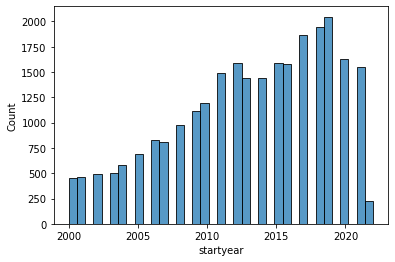

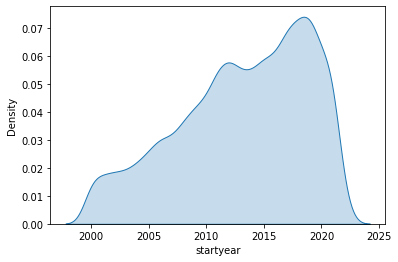

In [20]:
sns.histplot(data.startyear)
plt.savefig(f'../Images/2.3.a_startyear_hist.jpg')
plt.show()


sns.kdeplot(data.startyear, shade=True, label='data')
plt.savefig(f'../Images/2.3.a_num_startyear_kde.jpg')
plt.show()

##### 2.3.b - averagerating
- This is likely to be some sort of target in the future, linear regression would be great to take this project a step further.

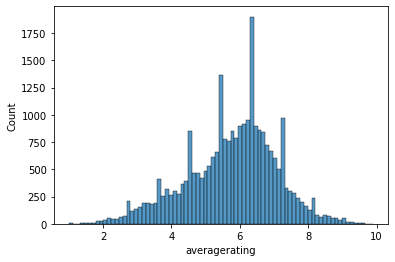

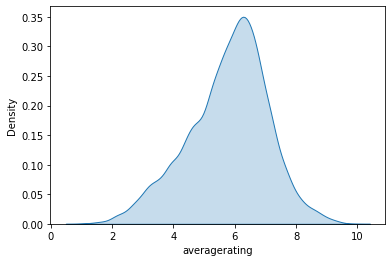

In [21]:
sns.histplot(data.averagerating)
plt.savefig(f'../Images/2.3.b_num_averagerating_hist.jpg')
plt.show()

sns.kdeplot(data.averagerating, shade=True, label='data')
plt.savefig(f'../Images/2.3.b_num_averagerating_kde.jpg')
plt.show()


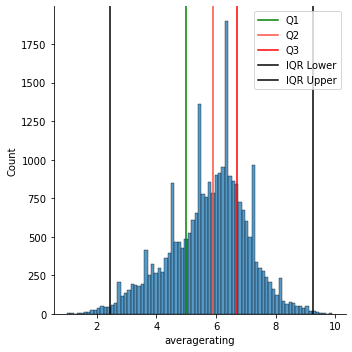

In [22]:
# Using Numpy I'll first calculate the IQR, then use it to identify and remove outliers found in the averagerating feature.
q1 = np.quantile(data.averagerating, 0.25)
q2 = np.quantile(data.averagerating, 0.5)
q3 = np.quantile(data.averagerating, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.averagerating)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.savefig(f'../Images/2.3.b_outliers_check_averagerating.jpg')
plt.show()
#TODO come back and trim this

In [23]:
# trimming off everything above and below the threshold.
# Intuition on this dictates that we want data that extreme outliers can lead to groupings - ansd their centroids, being dragged out due to these skewed data.
data = data[data.averagerating >= iqr_lower]
data = data[data.averagerating <= iqr_upper]

In [24]:
data.shape
# we've lost only a small number of rows.
#TODO get the original number and show difference.

(26198, 10)

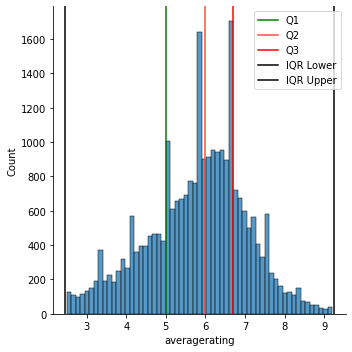

In [25]:

# checking out the new distribution using the new IQR.
q1 = np.quantile(data.averagerating, 0.25)
q2 = np.quantile(data.averagerating, 0.5)
q3 = np.quantile(data.averagerating, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.averagerating)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')

plt.legend()
plt.savefig(f'../Images/2.3.b_num_outliers_recheck_averagerating.jpg')
plt.show()



In [26]:
data = data[data.averagerating > iqr_lower]
data = data[data.averagerating < iqr_upper]
data.shape

(26198, 10)

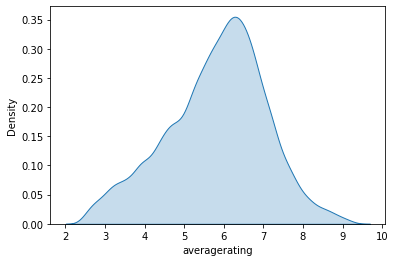

In [27]:
sns.kdeplot(data.averagerating, shade=True, label='data')
plt.savefig(f'../Images/2.3.b_num_averagerating_cleaned_kde.jpg')
plt.show()

In [28]:
# checking out these new summary stats
# the max is a more realistic two hours or so while the mean remains about the same. The standard deviation has also been halved.
data.averagerating.describe(include = 'all')

count    26198.000000
mean         5.806088
std          1.260121
min          2.500000
25%          5.000000
50%          6.000000
75%          6.700000
max          9.200000
Name: averagerating, dtype: float64

In [29]:
to_img(data.select_dtypes('number').head(), name='2.3_numeric_features_post')
data.select_dtypes('number')

,startyear,runtimeminutes,ordering,averagerating,numvotes
5,2018,122.0,3,6.7,7160
9,2002,126.0,1,5.7,810
10,2002,126.0,2,5.7,810
11,2002,126.0,3,5.7,810
27,2000,99.0,1,7.1,4254
...,...,...,...,...,...
69170,2019,111.0,3,4.5,29
69171,2020,97.0,1,7.0,3273
69182,2019,107.0,3,7.6,6
69183,2022,82.0,1,4.2,18


### 2.4 Feature Associations

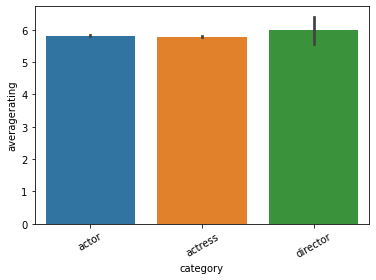

In [30]:
ax = sns.barplot(data=data,x=data.category,y=data.averagerating)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

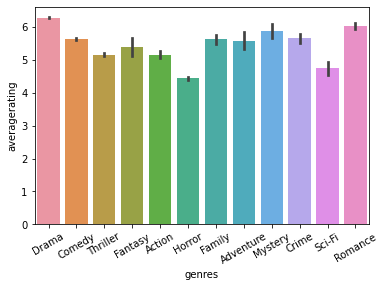

In [31]:
ax = sns.barplot(data=data,x=data.genres,y=data.averagerating)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()
#TODO sort this and amke wider for x labels

In [32]:
data.category.value_counts()

actor       15595
actress     10558
director       45
Name: category, dtype: int64

In [33]:
data.primarytitle.value_counts()

Home                           11
Last Call                      10
Alive                           8
100                             8
Forgiveness                     8
                               ..
Found Betty                     1
Angels on Tap                   1
Lucky Girl                      1
The Dying Light                 1
All the Cities of the North     1
Name: primarytitle, Length: 14672, dtype: int64

## 3. Feature Selection & Hyperparameter Tuning
After checking a range of cluster quantities I'm going to use principal component analysis from Sklearn to to reduce the dimensionality of the data. To deal with the categorical variables I'm going to encode them ordinally so can feed the information to the KNN++ model without having to draatically increase me feature space.


#### 3.1 Feature Selection

A key concept with PCA is that the first features considered matter the most - I'd originally struggled to get good metrics because of how I was feeding data in via the pipeline.
primaryname explodes when one hot encoded, primarytitle follows. Since I reduced genres down to a list of quintessential genres (i.e. not a list of genres. "Drama" vs "['Drama', 'Horror']").
In the cell below I'm setting up to run summary analysis on numeric features. Noting the difference in quantity between the appearance of unique values, I'm arranging the pipeline of their unique value.

In [34]:
ohe = ['category','genres','tconst','primaryname']
for i in ohe:
    print(f'{i} {data[i].nunique()}')

category 3
genres 12
tconst 15187
primaryname 9414


In [35]:
# preserving data so I can add clusters identified by KMeans++ as a new column later. 
X = data
ordi = OrdinalEncoder()
X['name'] = ordi.fit_transform(pd.DataFrame(X.primaryname))
X['const'] = ordi.fit_transform(pd.DataFrame(X.tconst))

to_img(X.head(10), name='3.1_X')
# feature encoding
ohe = ['category','genres']
scal_cols = ['startyear','averagerating','numvotes','runtimeminutes','name','const']

X


,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname,name,const
5,tt0069049,The Other Side of the Wind,2018,122.0,Drama,3,actor,6.7,7160,Peter Bogdanovich,6912.0,0.0
9,tt0096056,Crime and Punishment,2002,126.0,Drama,1,actor,5.7,810,Crispin Glover,1815.0,1.0
10,tt0096056,Crime and Punishment,2002,126.0,Drama,2,actress,5.7,810,Vanessa Redgrave,8917.0,1.0
11,tt0096056,Crime and Punishment,2002,126.0,Drama,3,actor,5.7,810,John Hurt,4121.0,1.0
27,tt0118852,Chinese Coffee,2000,99.0,Drama,1,actor,7.1,4254,Al Pacino,176.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69170,tt9900688,Big Three Dragons,2019,111.0,Comedy,3,actor,4.5,29,Chia-Chia Peng,1534.0,15182.0
69171,tt9902160,Herself,2020,97.0,Drama,1,actress,7.0,3273,Molly McCann,6277.0,15183.0
69182,tt9904552,All for the Money,2019,107.0,Comedy,3,actor,7.6,6,Simeon Henderson,8108.0,15184.0
69183,tt9904648,The Contrast,2022,82.0,Comedy,1,actor,4.2,18,Lance E. Nichols,4949.0,15185.0


### 3.2 Feature Encoding
I'm using a column transformer to encode the X, which is the same as data but with a selection of categorical features ordinally encoded. It will return x_train which I'll then use for finding the optimal number of centroids (k) and components (PCA).

In [36]:

preprocessor = ColumnTransformer(
    transformers=[
        #('ordi', OrdinalEncoder(), ordi),
        ('scaler', StandardScaler(), scal_cols),
        ('ohe', OneHotEncoder(handle_unknown ='ignore'), ohe)
        
        ],remainder='drop')


x_train = preprocessor.fit_transform(X)


In [37]:
# just looking to see what the training data looks like.
to_img(pd.DataFrame(x_train).head(10), name='3.2_x_train')
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.863170,0.709399,0.143314,1.298453,0.811551,-1.735808,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.969493,-0.084191,-0.104092,1.516738,-1.066404,-1.735579,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.969493,-0.084191,-0.104092,1.516738,1.550279,-1.735579,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.969493,-0.084191,-0.104092,1.516738,-0.216774,-1.735579,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.323575,1.026835,0.030092,0.043315,-1.670283,-1.735351,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26193,1.040211,-1.036498,-0.134521,0.698170,-1.169937,1.731893,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26194,1.217252,0.947476,-0.008130,-0.065828,0.577589,1.732121,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26195,1.040211,1.423630,-0.135417,0.479885,1.252209,1.732350,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26196,1.571335,-1.274575,-0.134949,-0.884397,0.088297,1.732578,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.3 Optimal K: Elbow Method

The inertia for : 1 Clusters is: 187431.84594243806
The inertia for : 2 Clusters is: 155264.33900609845
The inertia for : 3 Clusters is: 139632.1341222499
The inertia for : 4 Clusters is: 122266.34860405367
The inertia for : 5 Clusters is: 112178.32837553967
The inertia for : 6 Clusters is: 104021.47752096658
The inertia for : 7 Clusters is: 99160.42104581016
The inertia for : 8 Clusters is: 95490.67956697872
The inertia for : 9 Clusters is: 91030.76948923797
The inertia for : 10 Clusters is: 87709.14055637826
The inertia for : 11 Clusters is: 84742.12501478956
The inertia for : 12 Clusters is: 81890.27923849803
The inertia for : 13 Clusters is: 79392.8133277704
The inertia for : 14 Clusters is: 78442.89342700143


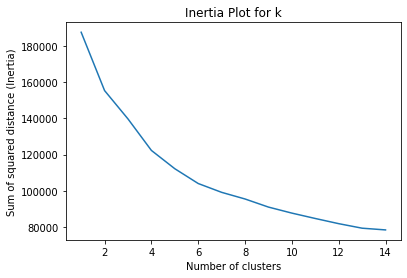

In [38]:
cs = []
c_dict = {}
n_clusters = [range(1, 15)]
for k in range(1, 15):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 30, n_init = 4, random_state = 42)
    kmeans.fit(x_train)
    cs.append(kmeans.inertia_)
    if k not in c_dict.keys():
        c_dict[k] = kmeans.inertia_

    print("The inertia for :", k, "Clusters is:", kmeans.inertia_)
plt.plot(range(1, 15), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance (Inertia)')
plt.title("Inertia Plot for k")
plt.savefig('../Images/3.3_hypertuning_kmeans_elbow_1.jpg')
plt.show()


In [39]:
# Using the best k shown by the elbow method to train a new model.
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 20, n_init = 8, random_state = 42)
kmeans.fit(x_train)

# saving for PCA
labels = set(kmeans.labels_)
# saving for PCA
y_pred = kmeans.predict(x_train)
# saving this to compare with final model
old_inertia = kmeans.inertia_
# labels for plot legend
target_labels = [f'Cluster {1+x}' for x in labels]
print(f'Model Inertia: {kmeans.inertia_}')
print(f'Model Label: {labels}')

Model Inertia: 104029.28685771256
Model Label: {0, 1, 2, 3, 4, 5}


### 3.4 Principal Component Analysis


In [40]:
n_components = 2
pca = PCA(n_components=n_components, random_state = 42)
X_r = pca.fit_transform(x_train)
to_img(pd.DataFrame(X_r).head(10), name='3.4_X_r_2_comp')
pd.DataFrame(X_r)

,0,1
0,0.682770,1.533443
1,2.510402,0.559275
2,2.450999,0.928781
3,2.503776,0.687059
4,2.972440,0.268337
...,...,...
26193,-2.058861,-0.346960
26194,-1.936467,0.982529
26195,-1.772854,1.514973
26196,-2.404425,-1.287333


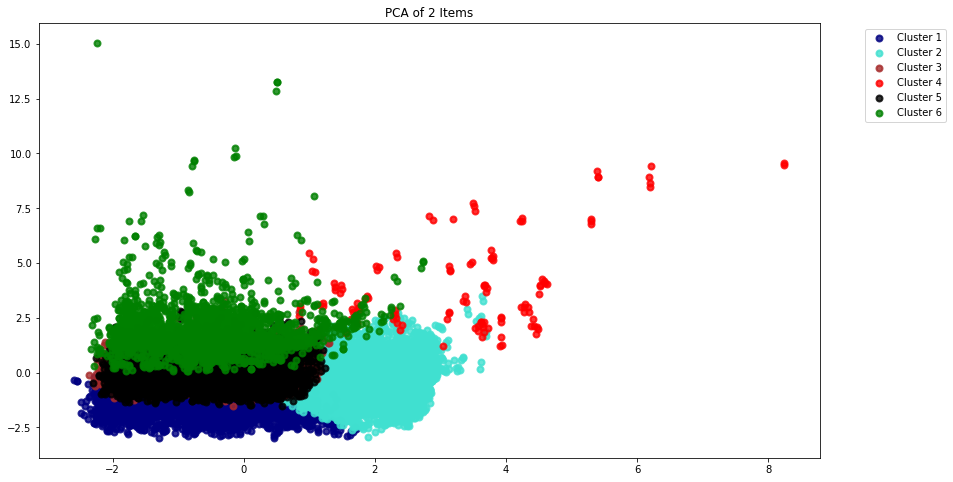

In [41]:
plt.figure(1, figsize=(14, 8))
for color, i, target_name in zip(colors[:len(target_labels)], list(range(len(target_labels))), target_labels):
    plt.scatter(X_r[y_pred == i, 0], X_r[y_pred == i, 1], color=color, alpha=.8, lw=2,label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title(f'PCA of {n_components} Items')
plt.savefig('../Images/3.4_hypertuning_PCA_2_comp.jpg')
plt.show()

In [42]:
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))


Explained variance ratio (first two components): [0.24042741 0.18497356]


#### 3.4.1 Finding Optimal N-Components Using Optimal K
In order to find the optimal number of components to abstract the feature set into I need to analyze the entire table to find both the total variance and its 95% percentile. The number of components that can reduce variance by 5% is what we'll go with.

In [43]:
# setting the number of components to being the total number of features as given by the .shape() tuple.
x_train.shape[1]

21

In [44]:
n_components = x_train.shape[1]
pca = PCA(n_components=n_components, random_state = 42)
X_r = pca.fit_transform(x_train)

to_img(pd.DataFrame(X_r).head(10), name='3.4.1_X_r_all_comp')
pd.DataFrame(X_r)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.682770,1.533443,-0.713611,-0.228901,0.537446,-0.428473,1.741145,0.588275,-0.125004,-0.071764,...,-0.015855,0.006161,-0.004102,-0.000052,-0.004645,-0.006052,0.001838,0.000065,1.288983e-15,-1.076835e-15
1,2.510402,0.559275,0.824731,-0.941791,1.516151,-0.375755,-0.295649,0.506757,-0.070915,0.001549,...,0.016436,0.012265,-0.004400,-0.001059,0.000503,-0.001628,0.000105,-0.000079,-3.359250e-16,4.413158e-18
2,2.450999,0.928781,-1.664073,-0.399446,1.227648,1.069931,-0.275584,0.296600,-0.089254,0.015489,...,0.001743,0.010864,-0.004326,-0.002564,-0.003427,-0.000561,-0.000698,-0.001379,1.591909e-16,3.933291e-17
3,2.503776,0.687059,0.006958,-0.764908,1.444822,-0.360902,-0.292492,0.495922,-0.073858,0.000061,...,0.016902,0.012031,-0.006406,-0.001003,-0.000194,-0.001963,-0.000043,-0.000285,-2.093266e-16,5.171806e-16
4,2.972440,0.268337,1.538637,-1.009959,-0.215827,-0.491506,-0.445114,0.306987,0.084922,-0.022634,...,0.002416,0.000908,-0.000497,0.006354,-0.000622,-0.000991,-0.000906,-0.001265,-3.973054e-16,3.593998e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26193,-2.058861,-0.346960,1.101156,0.125969,1.149344,-0.686928,-0.473983,-0.644251,-0.476638,-0.006568,...,0.009642,-0.008177,-0.006838,-0.007541,0.001904,0.000341,0.000283,-0.001424,2.942901e-17,3.119726e-17
26194,-1.936467,0.982529,-0.308387,0.083157,-1.065623,0.786775,-0.368415,0.122424,-0.064955,-0.013913,...,-0.023646,-0.012575,0.001425,0.000887,-0.003170,0.002114,-0.000227,-0.004231,1.799020e-17,4.677398e-17
26195,-1.772854,1.514973,-0.965297,0.074539,-0.765137,-0.765729,-0.330220,-1.206166,-0.124399,-0.107983,...,-0.033352,-0.015162,-0.007788,0.008051,-0.007357,-0.000597,0.000298,-0.004002,7.149624e-17,3.192767e-17
26196,-2.404425,-1.287333,-0.116365,0.741036,-0.016001,-0.728855,-0.062543,-0.498883,-0.581068,0.006683,...,0.014858,-0.019082,-0.008954,-0.009639,0.002885,-0.000978,-0.000844,-0.001676,5.699198e-17,4.399253e-18


Total Variance in our dataset is:  7.15470649091264
The 95% variance we want to have is:  6.796971166367008

Variance explained with 5 compononets:  5.762343913989157
Variance explained with 10 compononets:  7.041863028391861
Variance explained with 15 compononets:  7.138550560211219


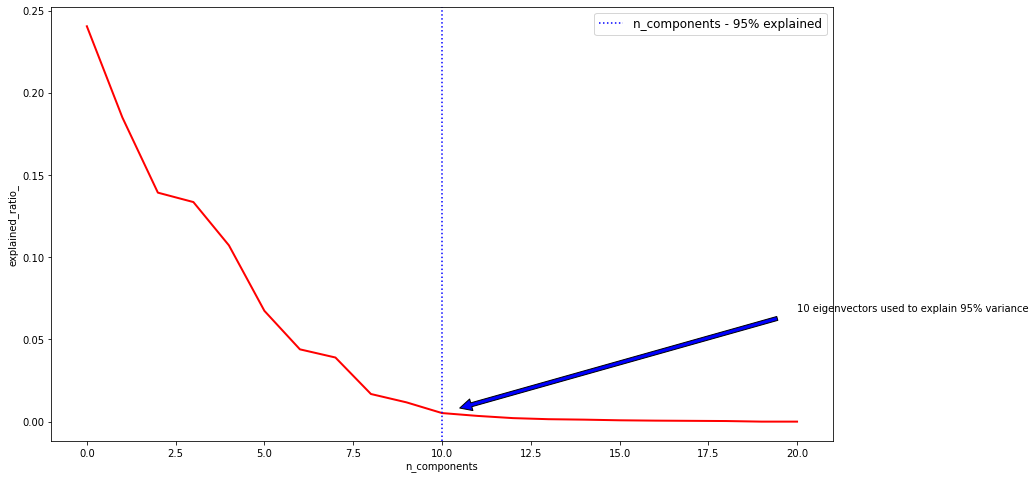

The best is 10 components which yields 7.041863028391861


In [45]:

total_variance = sum(pca.explained_variance_)
print('Total Variance in our dataset is: ', total_variance)
var_95 = total_variance * 0.95
print('The 95% variance we want to have is: ', var_95)
print('')
# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=['PCA Comp', 'Explained Variance'])

# Trying to hit 95%

d = 1
v = []
best = []

for i in range(len(a)):
    if len(v) > a.shape[0]*.9:
        if sum(v[-5:])/5 == v[:-1]:
            break
    else:
        v.append(sum(a['Explained Variance'][0:d]))
        if d%5 == 0:
            print(f'Variance explained with {d} compononets: ', sum(a['Explained Variance'][0:d]))
            if sum(a['Explained Variance'][0:d]) >= var_95:
                best.append((d,sum(a['Explained Variance'][0:d])))
        d += 1


best_c = best[0][0]
best_v = best[0][1]


# Plotting the Data
plt.figure(1, figsize=(14, 8))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c='r')
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')

# Plotting line with 95% e.v.
plt.axvline(best_c,linestyle=':', label='n_components - 95% explained', c ='blue')
plt.legend(prop=dict(size=12))

# adding arrow
plt.annotate(f'{best_c} eigenvectors used to explain 95% variance', xy=(best_c, pca.explained_variance_ratio_[best_c]), 
             xytext=(best_c+10, pca.explained_variance_ratio_[5]),
            arrowprops=dict(facecolor='blue', shrink=0.05))
plt.savefig('../Images/hypertuning_PCA_explanatory_components.jpg')
plt.show()

print(f'The best is {best_c} components which yields {best_v}')

#### 3.4.2 Rechecking For Optimal K-Means Using Optimal N-Components
Using PCA with this optimal number of components to add a preprocessing layer to the data before applying KMeans.

In [46]:
pca = PCA(n_components=best_c)
X_r = pca.fit_transform(x_train)

to_img(pd.DataFrame(X_r).head(10), name='3.4.2_X_r_best_comp')
pd.DataFrame(X_r)

,0,1,2,3,4,5,6,7,8,9
0,0.682770,1.533443,-0.713611,-0.228901,0.537446,-0.428473,1.741145,0.588275,-0.125004,-0.071764
1,2.510402,0.559275,0.824731,-0.941791,1.516151,-0.375755,-0.295649,0.506757,-0.070915,0.001549
2,2.450999,0.928781,-1.664073,-0.399446,1.227648,1.069931,-0.275584,0.296600,-0.089254,0.015489
3,2.503776,0.687059,0.006958,-0.764908,1.444822,-0.360902,-0.292492,0.495922,-0.073858,0.000061
4,2.972440,0.268337,1.538637,-1.009959,-0.215827,-0.491506,-0.445114,0.306987,0.084922,-0.022634
...,...,...,...,...,...,...,...,...,...,...
26193,-2.058861,-0.346960,1.101156,0.125969,1.149344,-0.686928,-0.473983,-0.644251,-0.476638,-0.006568
26194,-1.936467,0.982529,-0.308387,0.083157,-1.065623,0.786775,-0.368415,0.122424,-0.064955,-0.013913
26195,-1.772854,1.514973,-0.965297,0.074539,-0.765137,-0.765729,-0.330220,-1.206166,-0.124399,-0.107983
26196,-2.404425,-1.287333,-0.116365,0.741036,-0.016001,-0.728855,-0.062543,-0.498883,-0.581068,0.006683


The inertia for : 1 Clusters is: 184475.68575478188
The inertia for : 2 Clusters is: 152308.48948669183
The inertia for : 3 Clusters is: 136677.25710721847
The inertia for : 4 Clusters is: 119317.54220639763
The inertia for : 5 Clusters is: 109224.15736035655
The inertia for : 6 Clusters is: 101071.28690883309
The inertia for : 7 Clusters is: 96456.73902086643
The inertia for : 8 Clusters is: 91866.8176064301
The inertia for : 9 Clusters is: 87960.10817663271
The inertia for : 10 Clusters is: 84989.40727175874


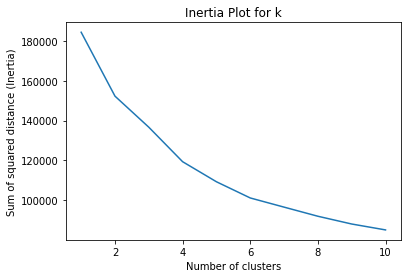

In [47]:
inertia = []
cs = []
n_clusters = [range(1, 11)]
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 20, n_init = 4, random_state = 42)
    kmeans.fit(X_r)
    cs.append(kmeans.inertia_)
    if k not in c_dict.keys():
        c_dict[k] = kmeans.inertia_

    print("The inertia for :", k, "Clusters is:", kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance (Inertia)')
plt.title("Inertia Plot for k")
plt.savefig('../Images/3.4.2_hypertuning_kmeans_elbow_2.jpg')
plt.show()

### 4. Training KMeans ++ with PCA

In [48]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 20, n_init = 4, random_state = 42)
kmeans.fit(X_r)

KMeans(max_iter=20, n_clusters=6, n_init=4, random_state=42)

In [49]:
y_pred = kmeans.predict(X_r)
y_pred


array([2, 5, 5, ..., 3, 0, 0], dtype=int32)

In [50]:
data['cluster'] = y_pred
to_img(pd.DataFrame(data).head(10), name='4_data_with_KMeans_pred_col')
data



,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname,name,const,cluster
5,tt0069049,The Other Side of the Wind,2018,122.0,Drama,3,actor,6.7,7160,Peter Bogdanovich,6912.0,0.0,2
9,tt0096056,Crime and Punishment,2002,126.0,Drama,1,actor,5.7,810,Crispin Glover,1815.0,1.0,5
10,tt0096056,Crime and Punishment,2002,126.0,Drama,2,actress,5.7,810,Vanessa Redgrave,8917.0,1.0,5
11,tt0096056,Crime and Punishment,2002,126.0,Drama,3,actor,5.7,810,John Hurt,4121.0,1.0,5
27,tt0118852,Chinese Coffee,2000,99.0,Drama,1,actor,7.1,4254,Al Pacino,176.0,2.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69170,tt9900688,Big Three Dragons,2019,111.0,Comedy,3,actor,4.5,29,Chia-Chia Peng,1534.0,15182.0,1
69171,tt9902160,Herself,2020,97.0,Drama,1,actress,7.0,3273,Molly McCann,6277.0,15183.0,3
69182,tt9904552,All for the Money,2019,107.0,Comedy,3,actor,7.6,6,Simeon Henderson,8108.0,15184.0,3
69183,tt9904648,The Contrast,2022,82.0,Comedy,1,actor,4.2,18,Lance E. Nichols,4949.0,15185.0,0


### 5. KMeans++ Model and PCA Evaluation

In [51]:
print(f'old inertia: {old_inertia}')
print(f'new inertia: {kmeans.inertia_}')
print(f'change:      {old_inertia-kmeans.inertia_}')

old inertia: 104029.28685771256
new inertia: 101071.28690883309
change:      2957.999948879471


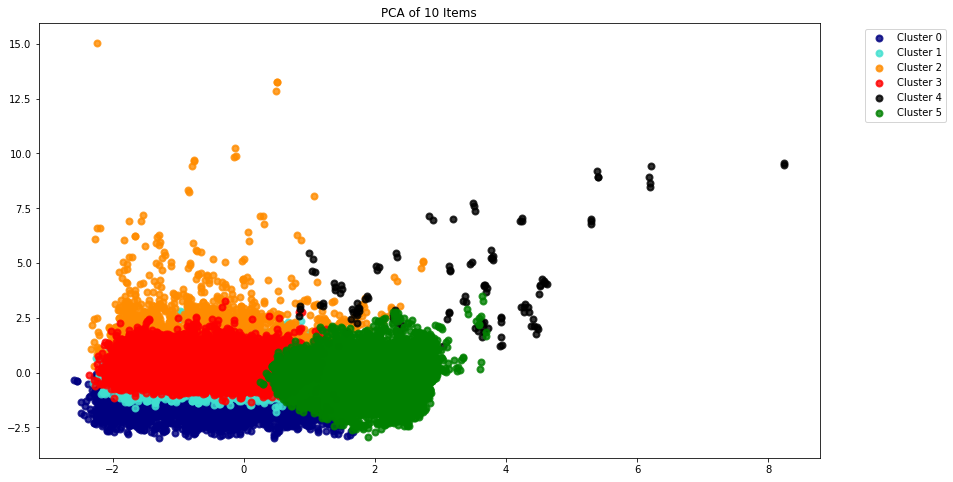

In [52]:
labels = set(kmeans.labels_)
target_labels = [f'Cluster {x}' for x in labels]
target_labels


plt.figure(1, figsize=(14, 8))

colors = ['navy', 'turquoise', 'darkorange', 'red', 'black','green', 'orange','pink']
for color, i, target_name in zip(colors[:len(target_labels)], list(range(len(target_labels))), target_labels):
    plt.scatter(X_r[y_pred == i, 0], X_r[y_pred == i, 1], color=color, alpha=.8, lw=2,label=target_name)



plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title(f'PCA of {best_c} Items')
plt.savefig('../Images/5_final_clusters.jpg')
plt.show()





### 6. Cluster Analysis

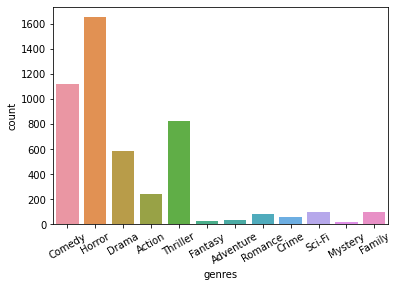

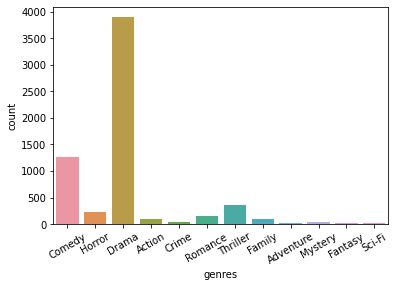

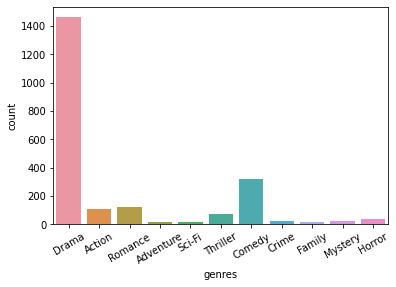

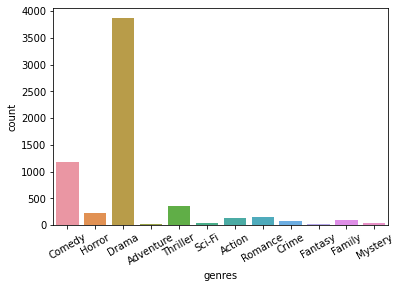

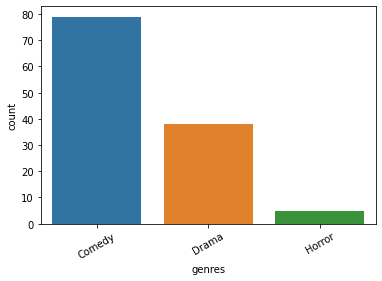

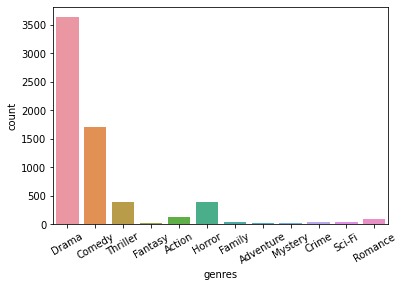

In [53]:

val_counts = []
for i in range(len(target_labels)):
    ax = sns.countplot(data=data[data.cluster == i], x='genres')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig(f'../Images/cluster_analysis_{i}_genres.jpg')
    plt.show()


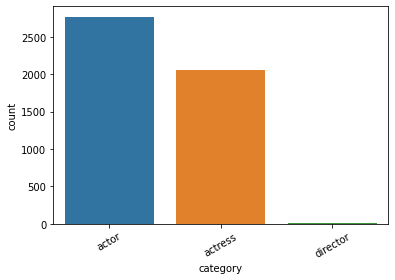

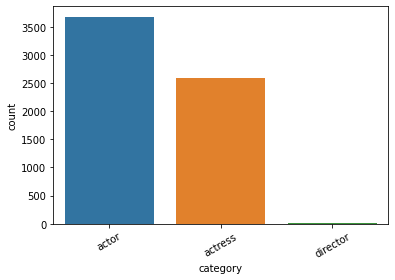

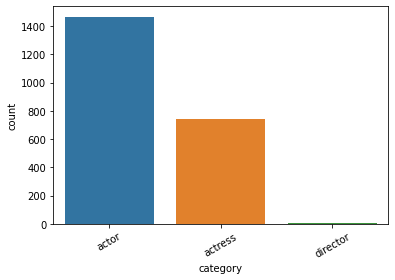

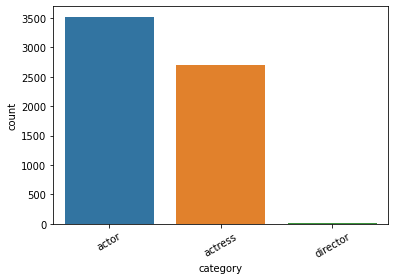

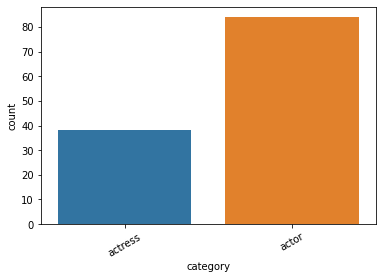

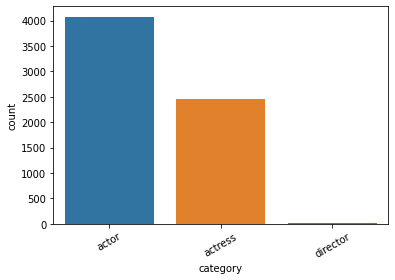

In [54]:
val_counts = []
for i in range(len(target_labels)):
    ax = sns.countplot(data=data[data.cluster == i], x='category')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    plt.savefig(f'../Images/cluster_analysis_{i}_categories.jpg')
    plt.show()

In [55]:
for i in range(len(target_labels)):
    print(data[data.cluster == i].primaryname.value_counts()[:5])

Eric Roberts      16
Kevin Sorbo       13
Michael Madsen    13
Tom Sizemore      11
Dean Cain         10
Name: primaryname, dtype: int64
Eric Roberts         17
Isabelle Huppert     13
Catherine Deneuve    11
Alba Rohrwacher      11
Céline Sallette      10
Name: primaryname, dtype: int64
Karamjit Anmol    8
Yogi Babu         8
Kôji Yakusho      7
Dileep            7
Lily Franky       7
Name: primaryname, dtype: int64
Valeria Golino        11
Sôsuke Ikematsu       11
Tom Sizemore          10
Valerio Mastandrea    10
Vivica A. Fox         10
Name: primaryname, dtype: int64
Seann William Scott    5
Will Ferrell           4
Jason Biggs            3
Seth Rogen             2
Vince Vaughn           2
Name: primaryname, dtype: int64
Joe Estevez         10
Michael Madsen       8
Gérard Depardieu     7
Bruno Todeschini     7
Daniel Baldwin       7
Name: primaryname, dtype: int64


In [56]:
for i in range(len(target_labels)):
    print(data[data.cluster == i].primarytitle.value_counts()[:5])

Last Call            6
The Penthouse        5
Wolf                 5
Heavy Duty           5
A Christmas Carol    5
Name: primarytitle, dtype: int64
High Society    5
Bad Seeds       5
Small Time      4
The Escape      4
Wildlife        4
Name: primarytitle, dtype: int64
Hamlet             6
100                4
Lovers             4
Restored Me        3
The Long Excuse    3
Name: primarytitle, dtype: int64
Cargo               6
Secret              5
Falling             4
Blackbird           4
A Moment of Love    3
Name: primarytitle, dtype: int64
There Will Be Blood    3
American Pie 2         3
Step Brothers          3
Superbad               3
Grown Ups              3
Name: primarytitle, dtype: int64
Home Sweet Home    6
Water              5
On the Edge        5
Peaches            5
Forgiveness        5
Name: primarytitle, dtype: int64


In [57]:
for i in range(len(target_labels)):
    print(data[data.cluster == i].genres.value_counts()[:5])

Horror      1654
Comedy      1117
Thriller     825
Drama        585
Action       242
Name: genres, dtype: int64
Drama       3894
Comedy      1273
Thriller     364
Horror       224
Romance      162
Name: genres, dtype: int64
Drama       1461
Comedy       319
Romance      124
Action       109
Thriller      74
Name: genres, dtype: int64
Drama       3868
Comedy      1183
Thriller     363
Horror       230
Romance      159
Name: genres, dtype: int64
Comedy    79
Drama     38
Horror     5
Name: genres, dtype: int64
Drama       3635
Comedy      1703
Horror       399
Thriller     391
Action       131
Name: genres, dtype: int64


In [58]:
for i in range(len(target_labels)):
    print(np.mean(data[data.cluster == i].numvotes))

872.3768115942029
1702.2660067060515
2557.320234869015
1631.8121192689964
310550.368852459
3461.8537743071506


In [59]:
for i in range(len(target_labels)):
    print(np.mean(data[data.cluster == i].startyear))

2015.6238095238095
2015.8127095641066
2015.8383017163505
2015.6696056428343
2008.032786885246
2005.4423518603583
